In [1]:
'''
Analyze ground truth, predictions, and audio of a given E2E model

Tunnel to remote server:
1) on boba `jupyter notebook --no-browser --port=8080`
2) on local `ssh -L 8080:localhost:8080 mkperez@boba.eecs.umich.edu`
3) open up web browser on local and play
'''

from IPython.display import Audio
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import librosa

# model_path = "/z/mkperez/speechbrain/AphasiaBank/results/duc_process_ES/No-LM/wavlm-large/freeze-True"
model_path = "/z/mkperez/speechbrain/AphasiaBank/results/duc_process_ES/No-LM/wavlm-large-mtl_paraphasia/freeze-True"
test_data_path = "/z/mkperez/speechbrain/AphasiaBank/data/Duc_process/test.csv"
data_df = pd.read_csv(test_data_path)
wer_txt = f"{model_path}/wer.txt"
cer_txt = f"{model_path}/cer.txt"
utt2wav = {row['ID']:row['wav'] for i,row in data_df.iterrows()}

with open(wer_txt, 'r') as r:
    wer_lines = r.readlines()

with open(cer_txt, 'r') as r:
    cer_lines = r.readlines()
    
assert len(wer_lines) == len(cer_lines), f'{len(wer_lines)} != {len(cer_lines)}'

100%|██████████| 57796/57796 [00:00<00:00, 151982.84it/s]


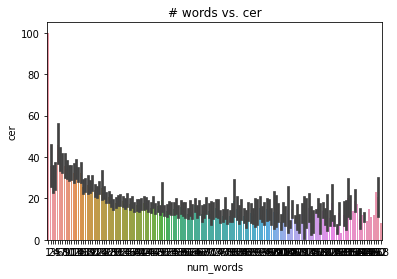

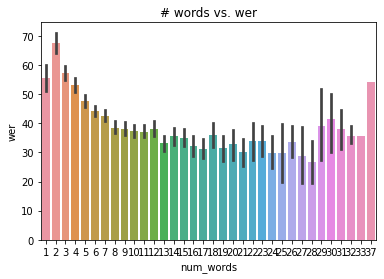

In [2]:
def read_wer_txt(lines):
    data = {}
    stage = 0
    for line in tqdm(lines):
        line = line.strip()
        if len(line.split()) == 14 and line.endswith("]"):
            # utt heading
            utt_id = line.split()[0][:-1]
            err = float(line.split()[2])
            data[utt_id] = {'gt':[],'pred':[], 'err':err}
            stage = 1
        elif stage == 1:
            data[utt_id]['gt'] = [t.strip() for t in line.split(";")]
            stage = 2
        elif stage == 2:
            stage = 3
            continue
        elif stage == 3:
            data[utt_id]['pred'] = [t.strip() for t in line.split(";")]
            stage = 0
    return data

wer_data = read_wer_txt(wer_lines)
cer_data = read_wer_txt(cer_lines)

for data_dict, err_str in zip([cer_data,wer_data],['cer','wer']):
    dflist=[]
    for utt_id,data in data_dict.items():
        df_loc=pd.DataFrame({
            'num_words': [len(data['gt'])],
            'err': [data['err']],
        })
        dflist.append(df_loc)
    df = pd.concat(dflist)
    # are errors more prevalent for shorter or longer utts?
    # wer/cer breakdown by number of words
    plt.clf()
    ax = sns.barplot(data=df, x='num_words',y='err')
    ax.set(title=f"# words vs. {err_str}", ylabel=err_str)
    fig = ax.get_figure()
    plt.show()



In [4]:
import IPython.display as ipd
import numpy as np

def get_audio_results(utt_id, cer_data, wer_data, utt2wav):
    cer = cer_data[utt_id]['err']
    wer = wer_data[utt_id]['err']
    gt = wer_data[utt_id]['gt']
    pred = wer_data[utt_id]['pred']
    audio_path = utt2wav[utt_id]
    print(f"{utt_id}: cer:{cer} | wer:{wer}\ngt:{gt}\npred:{pred}")
    ipd.display(ipd.Audio(filename=audio_path))

# sort by cer_err
sorted_cer_data = sorted(cer_data.items(), key=lambda x:x[1]['err'], reverse=True)


# keep utts with more than 3 words


# utt_id = 'scale10a-246'
# get_audio_results(utt_id, cer_data, wer_data, utt2wav)

# print worse 10
for i in range(5):
    tup = sorted_cer_data[i+0]
    utt_id = tup[0]
    get_audio_results(utt_id, cer_data, wer_data, utt2wav)
    print("\n")


elman01a-476: cer:733.33 | wer:400.0
gt:['ooh', '<eps>', '<eps>', '<eps>']
pred:['', 'tell', 'usstef', 'thatfooebla']




BU07a-304: cer:650.0 | wer:300.0
gt:['so', '<eps>', '<eps>', '<eps>']
pred:['so', 'howwil', 'te', 'do']




elman01a-480: cer:500.0 | wer:400.0
gt:['<eps>', 'its', '<eps>', '<eps>', '<eps>']
pred:['', 'its', 'theex', 't', 'thete']




kurland27c-3: cer:400.0 | wer:100.0
gt:['i', '<eps>']
pred:['i', 'oka']




MMA13a-351: cer:400.0 | wer:300.0
gt:['mhm', '<eps>', '<eps>']
pred:['', 'ti', 'gerellai']
